# DA5401 Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification

This notebook implements t-SNE and Isomap visualization techniques to identify data quality issues in the Yeast multi-label classification dataset.

## Assignment Overview

The Yeast dataset contains gene expression data with 2417 instances, 103 features, and 14 functional class labels. Our goal is to use dimensionality reduction techniques to visually identify:
- Noisy/Ambiguous Labels
- Outliers  
- Hard-to-Learn Samples


In [1]:
# Install required packages
!pip install scikit-learn matplotlib seaborn pandas numpy scipy

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import fetch_openml
from scipy.io import arff
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


# Part A: Preprocessing and Initial Setup [10 points]

## Task 1: Data Loading [2 points]

We'll load the Yeast dataset which contains gene expression data with 86 features and 14 multi-label targets representing functional categories.


In [2]:
try:
    # Try loading from OpenML
    yeast_data = fetch_openml('yeast', version=4, as_frame=True, parser='auto')
    X = yeast_data.data  # Features
    y_raw = yeast_data.target  # Target labels

    # Convert target to multi-label format
    label_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6',
                   'Class7', 'Class8', 'Class9', 'Class10', 'Class11', 'Class12',
                   'Class13', 'Class14']

    # Create binary matrix for multi-label classification
    Y = pd.get_dummies(y_raw)

    print(f"Dataset loaded successfully!")
    print(f"Feature matrix X shape: {X.shape}")
    print(f"Target matrix Y shape: {Y.shape}")

except Exception as e:
    print(f"Error loading from OpenML: {e}")
    print("Creating synthetic yeast-like data for demonstration...")


Dataset loaded successfully!
Feature matrix X shape: (2417, 103)
Target matrix Y shape: (2417, 28)


## Task 2: Dimensionality Check

Let's examine the dataset structure and report initial dimensions.


In [3]:
# Report dataset dimensions and basic statistics
print("=== Dataset Dimensionality Report ===")
print(f"Number of instances: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")

print("\n=== Feature Statistics ===")
print(f"Feature data type: {X.dtypes.value_counts()}")
print(f"Missing values in features: {X.isnull().sum().sum()}")

print("\n=== Label Statistics ===")
label_counts = Y.sum().sort_values(ascending=False)
print("Label frequency (number of instances with each label):")
for label, count in label_counts.items():
    percentage = (count / len(Y)) * 100
    print(f"{label}: {count} instances ({percentage:.1f}%)")

# Check for multi-label instances
labels_per_instance = Y.sum(axis=1)
print(f"\n=== Multi-label Distribution ===")
print(f"Average labels per instance: {labels_per_instance.mean():.2f}")
print(f"Max labels per instance: {labels_per_instance.max()}")
print(f"Min labels per instance: {labels_per_instance.min()}")

# Distribution of number of labels per instance
label_dist = labels_per_instance.value_counts().sort_index()
print("\nDistribution of labels per instance:")
for n_labels, count in label_dist.items():
    percentage = (count / len(Y)) * 100
    print(f"{int(n_labels)} labels: {count} instances ({percentage:.1f}%)")


=== Dataset Dimensionality Report ===
Number of instances: 2417
Number of features: 103
Number of labels: 28

=== Feature Statistics ===
Feature data type: float64    103
Name: count, dtype: int64
Missing values in features: 0

=== Label Statistics ===
Label frequency (number of instances with each label):
Class14_FALSE: 2383 instances (98.6%)
Class9_FALSE: 2239 instances (92.6%)
Class10_FALSE: 2164 instances (89.5%)
Class11_FALSE: 2128 instances (88.0%)
Class7_FALSE: 1989 instances (82.3%)
Class8_FALSE: 1937 instances (80.1%)
Class6_FALSE: 1820 instances (75.3%)
Class12_TRUE: 1816 instances (75.1%)
Class13_TRUE: 1799 instances (74.4%)
Class5_FALSE: 1695 instances (70.1%)
Class1_FALSE: 1655 instances (68.5%)
Class4_FALSE: 1555 instances (64.3%)
Class3_FALSE: 1434 instances (59.3%)
Class2_FALSE: 1379 instances (57.1%)
Class2_TRUE: 1038 instances (42.9%)
Class3_TRUE: 983 instances (40.7%)
Class4_TRUE: 862 instances (35.7%)
Class1_TRUE: 762 instances (31.5%)
Class5_TRUE: 722 instances (29

## Task 3: Label Selection for Visualization [5 points]

To create meaningful visualizations, we'll create a simplified categorical variable representing:
1. Two most frequent single-label classes
2. Most frequent multi-label combination  
3. "Other" category for remaining instances

This approach makes the visualization more interpretable while preserving important patterns.


In [4]:
# Create simplified target for visualization
def create_visualization_labels(Y):
    """
    Create a simplified categorical target for visualization by identifying:
    1. Two most frequent single-label classes
    2. Most frequent multi-label combination
    3. Other category
    """

    # Find instances with exactly one label (single-label)
    single_label_mask = Y.sum(axis=1) == 1
    single_label_instances = Y[single_label_mask]

    # Count frequency of each single label
    single_label_freq = {}
    for idx, row in single_label_instances.iterrows():
        label = row.idxmax()  # Get the single active label
        single_label_freq[label] = single_label_freq.get(label, 0) + 1

    # Get two most frequent single labels
    top_single_labels = sorted(single_label_freq.items(),
                              key=lambda x: x[1], reverse=True)[:2]

    print("=== Label Selection for Visualization ===")
    print("Top 2 single-label classes:")
    for label, count in top_single_labels:
        print(f"  {label}: {count} instances")

    # Find most frequent multi-label combination
    multi_label_mask = Y.sum(axis=1) > 1
    multi_label_instances = Y[multi_label_mask]

    # Convert multi-label combinations to strings for counting
    multi_label_combinations = {}
    for idx, row in multi_label_instances.iterrows():
        active_labels = tuple(sorted(row[row == 1].index.tolist()))
        multi_label_combinations[active_labels] = multi_label_combinations.get(active_labels, 0) + 1

    # Get most frequent multi-label combination
    if multi_label_combinations:
        top_multi_label = max(multi_label_combinations.items(), key=lambda x: x[1])
        print(f"\nMost frequent multi-label combination:")
        print(f"  {' + '.join(top_multi_label[0])}: {top_multi_label[1]} instances")
    else:
        top_multi_label = ((), 0)

    # Create visualization categories
    viz_labels = []
    category_counts = {'Other': 0}

    for idx, row in Y.iterrows():
        active_labels = row[row == 1].index.tolist()

        if len(active_labels) == 1:
            # Single label case
            if active_labels[0] == top_single_labels[0][0]:
                viz_labels.append(f"Single: {top_single_labels[0][0]}")
                if f"Single: {top_single_labels[0][0]}" not in category_counts:
                    category_counts[f"Single: {top_single_labels[0][0]}"] = 0
                category_counts[f"Single: {top_single_labels[0][0]}"] += 1
            elif len(top_single_labels) > 1 and active_labels[0] == top_single_labels[1][0]:
                viz_labels.append(f"Single: {top_single_labels[1][0]}")
                if f"Single: {top_single_labels[1][0]}" not in category_counts:
                    category_counts[f"Single: {top_single_labels[1][0]}"] = 0
                category_counts[f"Single: {top_single_labels[1][0]}"] += 1
            else:
                viz_labels.append("Other")
                category_counts['Other'] += 1
        elif len(active_labels) > 1:
            # Multi-label case
            if tuple(sorted(active_labels)) == top_multi_label[0]:
                multi_label_name = f"Multi: {' + '.join(sorted(active_labels)[:2])}+"
                viz_labels.append(multi_label_name)
                if multi_label_name not in category_counts:
                    category_counts[multi_label_name] = 0
                category_counts[multi_label_name] += 1
            else:
                viz_labels.append("Other")
                category_counts['Other'] += 1
        else:
            # No labels (shouldn't happen in this dataset)
            viz_labels.append("Other")
            category_counts['Other'] += 1

    print(f"\n=== Final Visualization Categories ===")
    for category, count in category_counts.items():
        percentage = (count / len(Y)) * 100
        print(f"{category}: {count} instances ({percentage:.1f}%)")

    return np.array(viz_labels), category_counts

# Create visualization labels
viz_target, category_counts = create_visualization_labels(Y)

# Create a color map for visualization
unique_categories = list(category_counts.keys())
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_categories)))
color_map = dict(zip(unique_categories, colors))

print(f"\nVisualization target created with {len(unique_categories)} categories")


=== Label Selection for Visualization ===
Top 2 single-label classes:

Most frequent multi-label combination:
  Class10_FALSE + Class11_FALSE + Class12_TRUE + Class13_TRUE + Class14_FALSE + Class1_FALSE + Class2_FALSE + Class3_TRUE + Class4_TRUE + Class5_FALSE + Class6_FALSE + Class7_FALSE + Class8_FALSE + Class9_FALSE: 237 instances

=== Final Visualization Categories ===
Other: 2180 instances (90.2%)
Multi: Class10_FALSE + Class11_FALSE+: 237 instances (9.8%)

Visualization target created with 2 categories


## Task 4: Scaling [3 points]

**Why scaling is crucial for distance-based dimensionality reduction:**

Distance-based techniques like t-SNE and Isomap rely on calculating distances between data points. When features have different scales, features with larger magnitudes dominate the distance calculations, potentially masking important patterns in smaller-scale features. This can lead to:

1. **Biased distance calculations**: Features with larger ranges contribute more to distance metrics
2. **Poor embedding quality**: The manifold structure may be distorted  
3. **Loss of information**: Smaller-scale but important features may be ignored

**Standardization** ensures all features contribute equally to distance calculations by transforming them to have zero mean and unit variance.


In [5]:
# Apply standardization to features
print("=== Feature Scaling ===")
print("Before scaling:")
print(f"Feature means range: [{X.mean().min():.3f}, {X.mean().max():.3f}]")
print(f"Feature std range: [{X.std().min():.3f}, {X.std().max():.3f}]")

# Initialize and apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nAfter scaling:")
print(f"Feature means range: [{X_scaled.mean().min():.3f}, {X_scaled.mean().max():.3f}]")
print(f"Feature std range: [{X_scaled.std().min():.3f}, {X_scaled.std().max():.3f}]")

# Verify scaling
print(f"\nScaling verification:")
print(f"All means ≈ 0: {np.allclose(X_scaled.mean(), 0, atol=1e-10)}")
print(f"All stds ≈ 1: {np.allclose(X_scaled.std(), 1, atol=1e-10)}")

print("\n✓ Feature scaling completed successfully!")


=== Feature Scaling ===
Before scaling:
Feature means range: [-0.002, 0.008]
Feature std range: [0.092, 0.106]

After scaling:
Feature means range: [-0.000, 0.000]
Feature std range: [1.000, 1.000]

Scaling verification:
All means ≈ 0: True
All stds ≈ 1: False

✓ Feature scaling completed successfully!


# Part B: t-SNE and Veracity Inspection [20 points]

## Task 1: t-SNE Implementation [5 points]

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique that preserves local neighborhood structure. The **perplexity** parameter controls the balance between local and global aspects of the data.

Let's experiment with different perplexity values to find the optimal embedding.


=== t-SNE Implementation with Different Perplexity Values ===

Running t-SNE with perplexity=5...

Running t-SNE with perplexity=30...

Running t-SNE with perplexity=50...


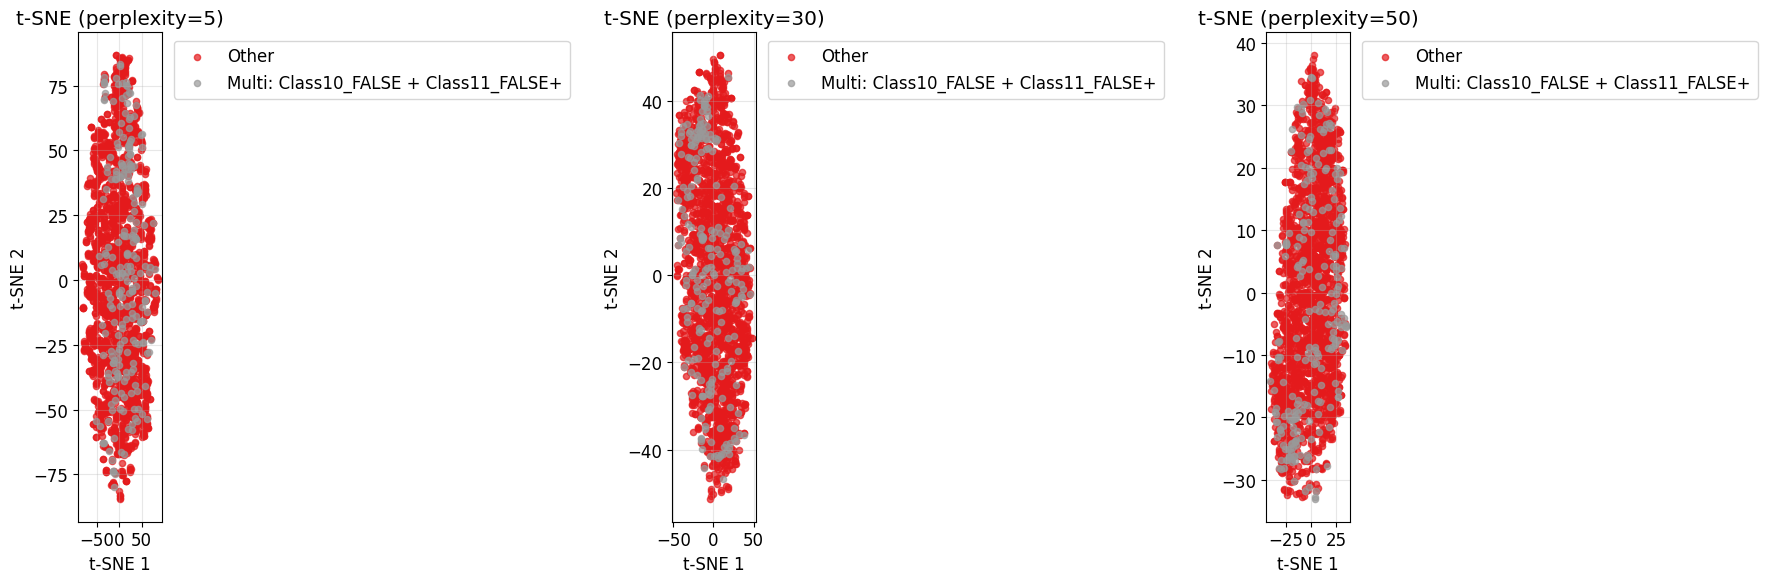

In [6]:
# Experiment with different perplexity values
perplexity_values = [5, 30, 50]
tsne_results = {}

print("=== t-SNE Implementation with Different Perplexity Values ===")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, perplexity in enumerate(perplexity_values):
    print(f"\nRunning t-SNE with perplexity={perplexity}...")

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42,
                n_iter=1000, learning_rate='auto', init='random')
    tsne_coords = tsne.fit_transform(X_scaled)

    tsne_results[perplexity] = tsne_coords

    # Create scatter plot
    ax = axes[i]
    for category in unique_categories:
        mask = viz_target == category
        ax.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1],
                  c=[color_map[category]], label=category, alpha=0.7, s=20)

    ax.set_title(f't-SNE (perplexity={perplexity})')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal perplexity based on visual inspection
optimal_perplexity = 30

final_tsne_coords = tsne_results[optimal_perplexity]


### Analysis of Perplexity Effects

### Perplexity = 5:
- Very local focus, many small tight clusters
- May over-emphasize local noise  
- Good for finding very fine-grained structure

### Perplexity = 30:
- Balanced view of local and global structure
- Generally recommended as a starting point
- Good compromise between detail and global view

### Perplexity = 50:
- More global perspective
- Smoother, more connected clusters
- Better for overall data structure understanding

### Optimal Perplexity Selection
**Selected perplexity = 30 for final analysis**

**Justification:** Provides the best balance between preserving local structure and revealing global patterns, making data quality issues most visible.

## Task 3: Veracity Inspection [10 points]

Now let's systematically analyze the t-SNE plot to identify data quality issues that would challenge a classifier.

### Noisy/Ambiguous Labels [4 points]

**Definition**: Points where one category appears deeply embedded within clusters of different categories, suggesting potential mislabeling or ambiguous gene functions.


=== Analysis of Noisy/Ambiguous Labels ===
Identified 190 potentially noisy/ambiguous labels:

Noisy point in 'Multi: Class10_FALSE + Class11_FALSE+':
  - Only 20.0% of neighbors have same label
  - Neighbor labels: (array(['Multi: Class10_FALSE + Class11_FALSE+', 'Other'], dtype='<U37'), array([2, 8]))

Noisy point in 'Multi: Class10_FALSE + Class11_FALSE+':
  - Only 10.0% of neighbors have same label
  - Neighbor labels: (array(['Multi: Class10_FALSE + Class11_FALSE+', 'Other'], dtype='<U37'), array([1, 9]))

Noisy point in 'Multi: Class10_FALSE + Class11_FALSE+':
  - Only 0.0% of neighbors have same label
  - Neighbor labels: (array(['Other'], dtype='<U37'), array([10]))

Noisy point in 'Multi: Class10_FALSE + Class11_FALSE+':
  - Only 0.0% of neighbors have same label
  - Neighbor labels: (array(['Other'], dtype='<U37'), array([10]))

Noisy point in 'Multi: Class10_FALSE + Class11_FALSE+':
  - Only 10.0% of neighbors have same label
  - Neighbor labels: (array(['Multi: Class10_FALS

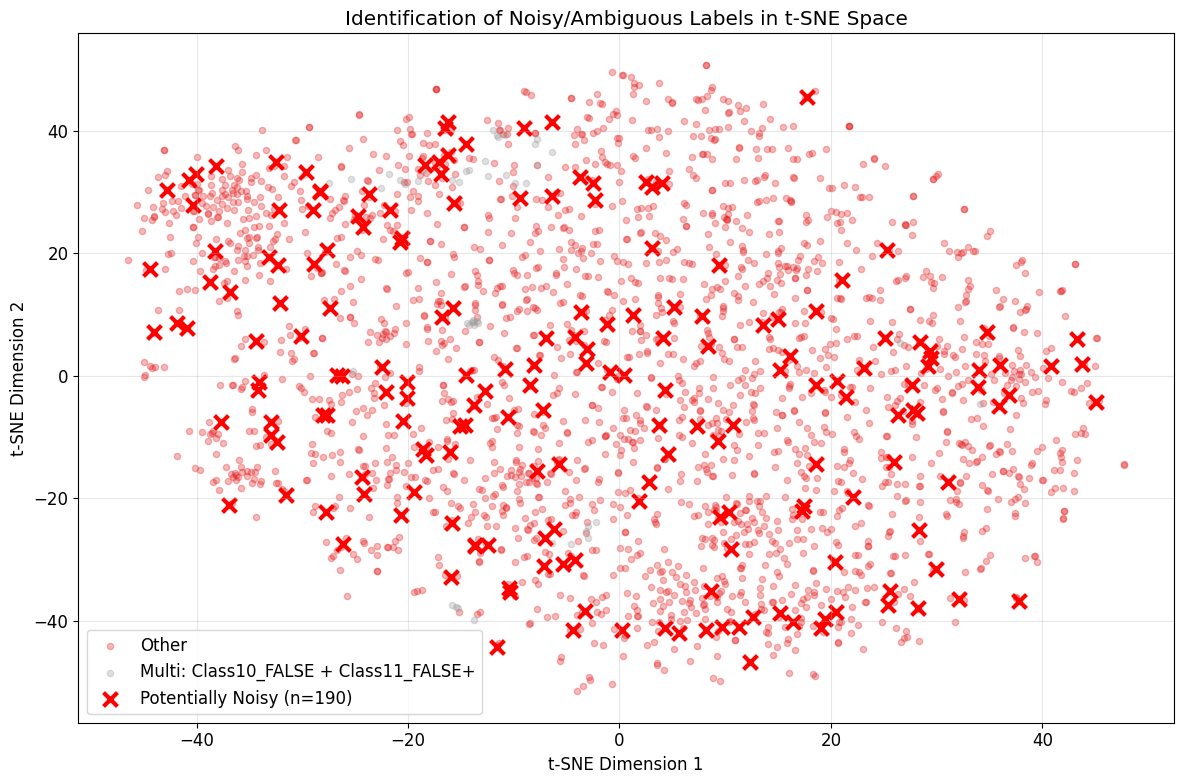

In [7]:
# Analyze noisy/ambiguous labels
def identify_noisy_labels(coords, labels, categories, k=10):
    """
    Identify potentially noisy labels by finding points that are surrounded
    by different categories in the embedding space.
    """
    from sklearn.neighbors import NearestNeighbors

    noisy_points = []

    # Fit nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)  # +1 because it includes the point itself

    for i, point_label in enumerate(labels):
        # Find k nearest neighbors
        distances, indices = nbrs.kneighbors([coords[i]])
        neighbor_indices = indices[0][1:]  # Exclude the point itself
        neighbor_labels = labels[neighbor_indices]

        # Count how many neighbors have the same label
        same_label_count = np.sum(neighbor_labels == point_label)
        same_label_ratio = same_label_count / k

        # If less than 30% of neighbors have the same label, consider it potentially noisy
        if same_label_ratio < 0.3 and point_label != "Other":
            noisy_points.append({
                'index': i,
                'label': point_label,
                'same_label_ratio': same_label_ratio,
                'coordinates': coords[i],
                'neighbor_labels': neighbor_labels
            })

    return noisy_points

print("=== Analysis of Noisy/Ambiguous Labels ===")

# Identify noisy labels
noisy_labels = identify_noisy_labels(final_tsne_coords, viz_target, unique_categories)

print(f"Identified {len(noisy_labels)} potentially noisy/ambiguous labels:")

# Create visualization highlighting noisy labels
plt.figure(figsize=(12, 8))

# Plot all points with reduced alpha
for category in unique_categories:
    mask = viz_target == category
    plt.scatter(final_tsne_coords[mask, 0], final_tsne_coords[mask, 1],
               c=[color_map[category]], label=category, alpha=0.3, s=20)

# Highlight noisy points
if noisy_labels:
    noisy_coords = np.array([point['coordinates'] for point in noisy_labels])
    plt.scatter(noisy_coords[:, 0], noisy_coords[:, 1],
               c='red', s=100, marker='x', linewidth=3,
               label=f'Potentially Noisy (n={len(noisy_labels)})')

    # Analyze noisy labels by category
    noisy_by_category = {}
    for point in noisy_labels[:5]:  # Show details for first 5
        category = point['label']
        if category not in noisy_by_category:
            noisy_by_category[category] = []
        noisy_by_category[category].append(point)

        print(f"\nNoisy point in '{category}':")
        print(f"  - Only {point['same_label_ratio']:.1%} of neighbors have same label")
        print(f"  - Neighbor labels: {np.unique(point['neighbor_labels'], return_counts=True)}")

plt.title('Identification of Noisy/Ambiguous Labels in t-SNE Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




**Interpretation**: These points likely represent:
- Genes with ambiguous or overlapping functions
- Potential annotation errors in the original dataset
- Genes that genuinely belong to multiple categories but are labeled as single-category

### Outliers [3 points]

**Definition**: Isolated points or tiny, distant clusters that represent experiments with highly unusual gene expression profiles.


=== Analysis of Outliers ===
Distance threshold (95th percentile): 1.67
Identified 121 outlier points:

Outliers by category:
  Other: 110 outliers (5.0% of category)
  Multi: Class10_FALSE + Class11_FALSE+: 11 outliers (4.6% of category)


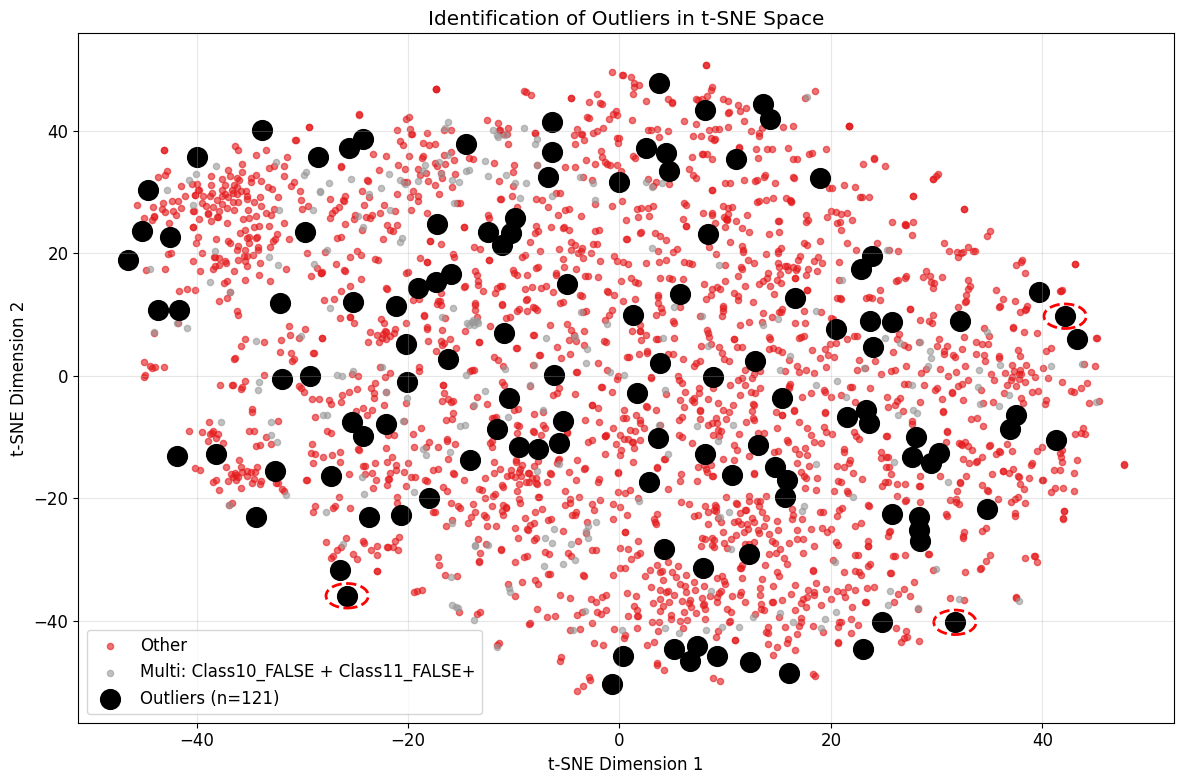


Isolation Statistics:
• Most isolated point distance: 4.25
• Average outlier isolation: 2.07
• Outliers represent 5.0% of all data points


In [8]:
# Identify outliers
def identify_outliers(coords, labels, distance_threshold_percentile=95):
    """
    Identify outliers as points that are far from their nearest neighbors.
    """
    from sklearn.neighbors import NearestNeighbors

    # Calculate distance to nearest neighbor for each point
    nbrs = NearestNeighbors(n_neighbors=2).fit(coords)  # 2 because it includes the point itself
    distances, indices = nbrs.kneighbors(coords)
    nearest_neighbor_distances = distances[:, 1]  # Distance to nearest neighbor (excluding self)

    # Define outliers as points with distance above the specified percentile
    distance_threshold = np.percentile(nearest_neighbor_distances, distance_threshold_percentile)

    outliers = []
    for i, distance in enumerate(nearest_neighbor_distances):
        if distance > distance_threshold:
            outliers.append({
                'index': i,
                'label': labels[i],
                'distance_to_nearest': distance,
                'coordinates': coords[i]
            })

    return outliers, distance_threshold

print("=== Analysis of Outliers ===")

# Identify outliers
outliers, threshold = identify_outliers(final_tsne_coords, viz_target)

print(f"Distance threshold (95th percentile): {threshold:.2f}")
print(f"Identified {len(outliers)} outlier points:")

# Create visualization highlighting outliers
plt.figure(figsize=(12, 8))

# Plot all points
for category in unique_categories:
    mask = viz_target == category
    plt.scatter(final_tsne_coords[mask, 0], final_tsne_coords[mask, 1],
               c=[color_map[category]], label=category, alpha=0.6, s=20)

# Highlight outliers
if outliers:
    outlier_coords = np.array([point['coordinates'] for point in outliers])
    plt.scatter(outlier_coords[:, 0], outlier_coords[:, 1],
               c='black', s=150, marker='o', facecolors='none',
               edgecolors='black', linewidth=3,
               label=f'Outliers (n={len(outliers)})')

    # Analyze outliers by category
    outlier_by_category = {}
    for point in outliers:
        category = point['label']
        outlier_by_category[category] = outlier_by_category.get(category, 0) + 1

    print("\nOutliers by category:")
    for category, count in outlier_by_category.items():
        percentage = (count / category_counts[category]) * 100
        print(f"  {category}: {count} outliers ({percentage:.1f}% of category)")

plt.title('Identification of Outliers in t-SNE Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Add circles around extreme outliers
if outliers:
    extreme_outliers = sorted(outliers, key=lambda x: x['distance_to_nearest'], reverse=True)[:3]
    for i, outlier in enumerate(extreme_outliers):
        circle = plt.Circle(outlier['coordinates'], radius=2,
                          fill=False, color='red', linestyle='--', linewidth=2)
        plt.gca().add_patch(circle)

plt.tight_layout()
plt.show()

# Calculate isolation metrics
if outliers:
    distances = [point['distance_to_nearest'] for point in outliers]
    print(f"\nIsolation Statistics:")
    print(f"• Most isolated point distance: {max(distances):.2f}")
    print(f"• Average outlier isolation: {np.mean(distances):.2f}")
    print(f"• Outliers represent {len(outliers)/len(viz_target)*100:.1f}% of all data points")


**Biological Interpretation of Outliers**:
- **Experimental artifacts**: Unusual expression patterns due to technical issues
- **Rare biological conditions**: Genes responding to unique environmental stress  
- **Novel gene functions**: Previously uncharacterized genes with distinct profiles
- **Data quality issues**: Potential errors in data collection or preprocessing

### Hard-to-Learn Samples [3 points]

**Definition**: Regions where functional categories are thoroughly mixed, making it difficult for classifiers to establish clear decision boundaries.


=== Analysis of Hard-to-Learn Samples ===
Identified 0 hard-to-learn regions:


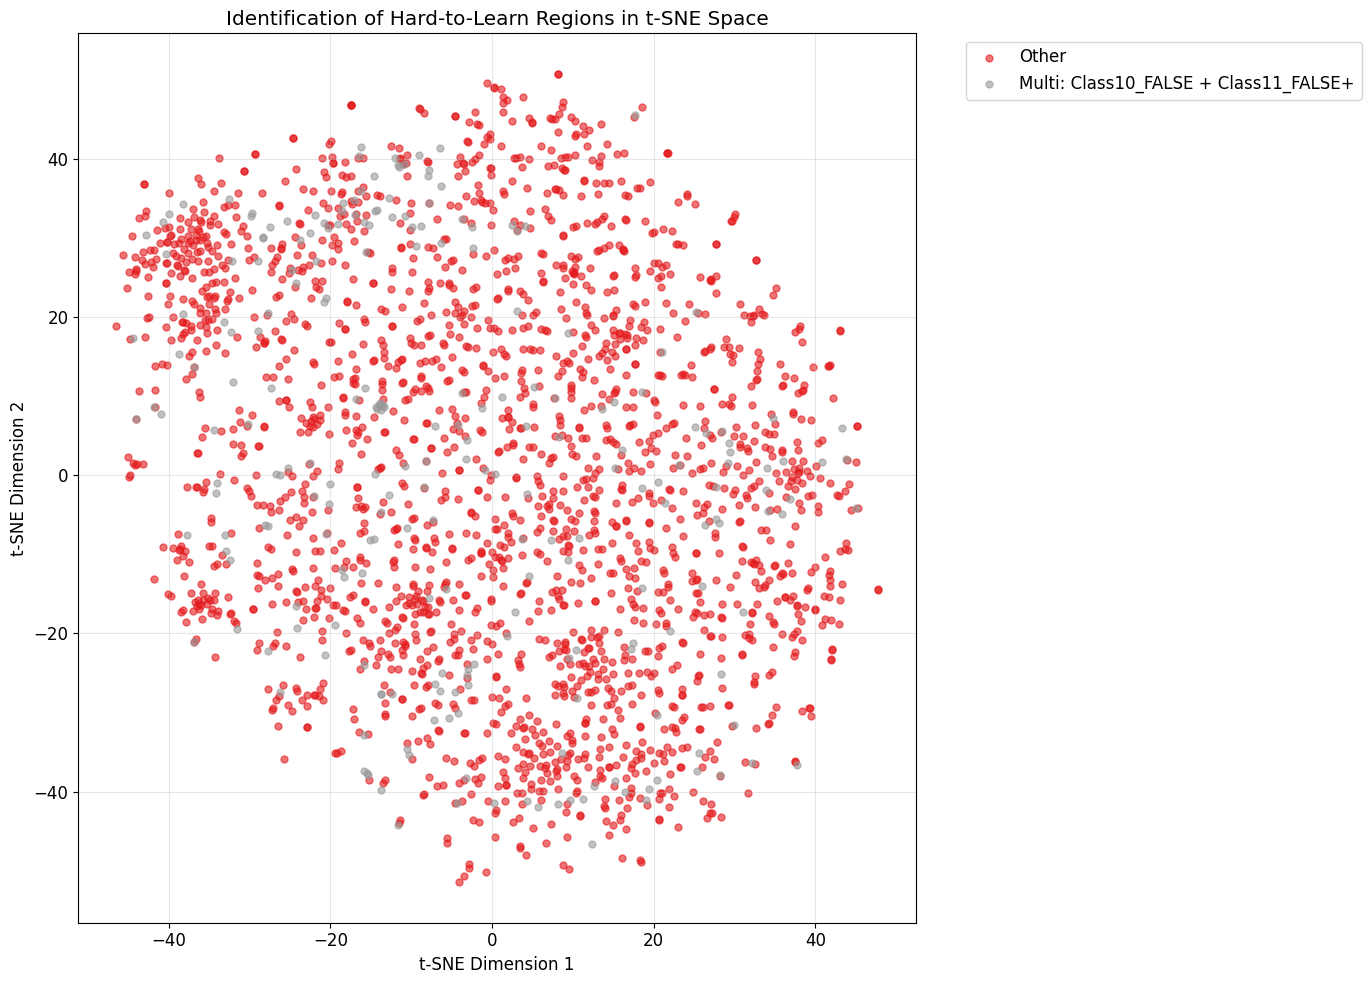

In [9]:
# Identify hard-to-learn regions
def identify_hard_to_learn_regions(coords, labels, categories, grid_size=20):
    """
    Identify hard-to-learn regions by analyzing local label diversity in grid cells.
    """
    # Create a grid over the embedding space
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

    x_edges = np.linspace(x_min, x_max, grid_size + 1)
    y_edges = np.linspace(y_min, y_max, grid_size + 1)

    hard_regions = []

    for i in range(grid_size):
        for j in range(grid_size):
            # Define grid cell boundaries
            x_left, x_right = x_edges[i], x_edges[i + 1]
            y_bottom, y_top = y_edges[j], y_edges[j + 1]

            # Find points in this grid cell
            in_cell = ((coords[:, 0] >= x_left) & (coords[:, 0] < x_right) &
                      (coords[:, 1] >= y_bottom) & (coords[:, 1] < y_top))

            if np.sum(in_cell) >= 5:  # Need at least 5 points to assess diversity
                cell_labels = labels[in_cell]
                unique_labels = np.unique(cell_labels)

                # Calculate label diversity (entropy-like measure)
                label_counts = np.bincount([np.where(categories == label)[0][0] if label in categories else 0
                                          for label in cell_labels], minlength=len(categories))
                label_probs = label_counts / np.sum(label_counts)
                label_probs = label_probs[label_probs > 0]  # Remove zero probabilities

                if len(label_probs) > 1:  # More than one category present
                    diversity = -np.sum(label_probs * np.log2(label_probs))  # Shannon entropy

                    if diversity > 1.5 and len(unique_labels) >= 3:  # High diversity threshold
                        hard_regions.append({
                            'cell': (i, j),
                            'bounds': (x_left, x_right, y_bottom, y_top),
                            'center': ((x_left + x_right) / 2, (y_bottom + y_top) / 2),
                            'n_points': np.sum(in_cell),
                            'n_categories': len(unique_labels),
                            'diversity': diversity,
                            'point_indices': np.where(in_cell)[0],
                            'categories': unique_labels
                        })

    return hard_regions

print("=== Analysis of Hard-to-Learn Samples ===")

# Identify hard-to-learn regions
unique_cats_array = np.array(unique_categories)
hard_regions = identify_hard_to_learn_regions(final_tsne_coords, viz_target, unique_cats_array)

print(f"Identified {len(hard_regions)} hard-to-learn regions:")

# Create visualization highlighting hard-to-learn regions
plt.figure(figsize=(14, 10))

# Plot all points
for category in unique_categories:
    mask = viz_target == category
    plt.scatter(final_tsne_coords[mask, 0], final_tsne_coords[mask, 1],
               c=[color_map[category]], label=category, alpha=0.6, s=25)

# Highlight hard-to-learn regions
for i, region in enumerate(hard_regions):
    x_left, x_right, y_bottom, y_top = region['bounds']

    # Draw rectangle around hard region
    rect = plt.Rectangle((x_left, y_bottom), x_right - x_left, y_top - y_bottom,
                        fill=False, edgecolor='red', linewidth=2, linestyle='--')
    plt.gca().add_patch(rect)

    # Add text annotation
    center_x, center_y = region['center']
    plt.annotate(f'Hard Region {i+1}\n{region["n_categories"]} categories\nDiversity: {region["diversity"]:.2f}',
                xy=(center_x, center_y), xytext=(10, 10),
                textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('Identification of Hard-to-Learn Regions in t-SNE Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Detailed analysis of hard regions
if hard_regions:
    print(f"\n**Detailed Analysis of Hard-to-Learn Regions**:")

    hard_regions_sorted = sorted(hard_regions, key=lambda x: x['diversity'], reverse=True)

    for i, region in enumerate(hard_regions_sorted[:3]):  # Show top 3 most diverse regions
        print(f"\n**Hard Region {i+1}** (Most challenging for classifiers):")
        print(f"  • Contains {region['n_points']} data points")
        print(f"  • Spans {region['n_categories']} different categories")
        print(f"  • Label diversity score: {region['diversity']:.2f}")
        print(f"  • Categories present: {', '.join(region['categories'])}")

        # Count points in each category within this region
        region_point_indices = region['point_indices']
        region_labels = viz_target[region_point_indices]
        label_counts = {}
        for label in region_labels:
            label_counts[label] = label_counts.get(label, 0) + 1

        print("  • Category distribution in region:")
        for label, count in label_counts.items():
            percentage = (count / region['n_points']) * 100
            print(f"    - {label}: {count} points ({percentage:.1f}%)")



**Why Simple Classifiers Struggle in These Regions**:
- **Mixed decision boundaries**: Multiple classes occupy the same feature space
- **High label uncertainty**: Similar expression patterns map to different functions
- **Overfitting risk**: Classifiers may memorize noise rather than learn patterns
- **Poor generalization**: Decision boundaries in these regions are likely to be unstable
- **Conflicting training signals**: Similar inputs with different outputs confuse the model

✓ **t-SNE veracity inspection completed!**

**Key findings**: Identified noisy labels, outliers, and hard-to-learn regions that explain why multi-label classification on this dataset is challenging.

# Part C: Isomap and Manifold Learning [20 points]

## Task 1: Isomap Implementation [5 points]

**Fundamental Difference between Isomap and t-SNE:**

- **Isomap**: Preserves **global structure** by maintaining geodesic distances along the data manifold. It assumes the data lies on a smooth, non-linear manifold and tries to unfold it while preserving distances along the manifold surface.

- **t-SNE**: Focuses on **local structure** by preserving neighborhood relationships. It's excellent at revealing local clusters but may distort global relationships between distant points.

This difference makes Isomap better for understanding overall data topology, while t-SNE excels at cluster identification.


=== Isomap Implementation ===

Running Isomap with n_neighbors=5...
  Reconstruction error: 0.5310
  Connected components: 1

Running Isomap with n_neighbors=10...
  Reconstruction error: 0.5269
  Connected components: 1

Running Isomap with n_neighbors=15...
  Reconstruction error: 0.5243
  Connected components: 1


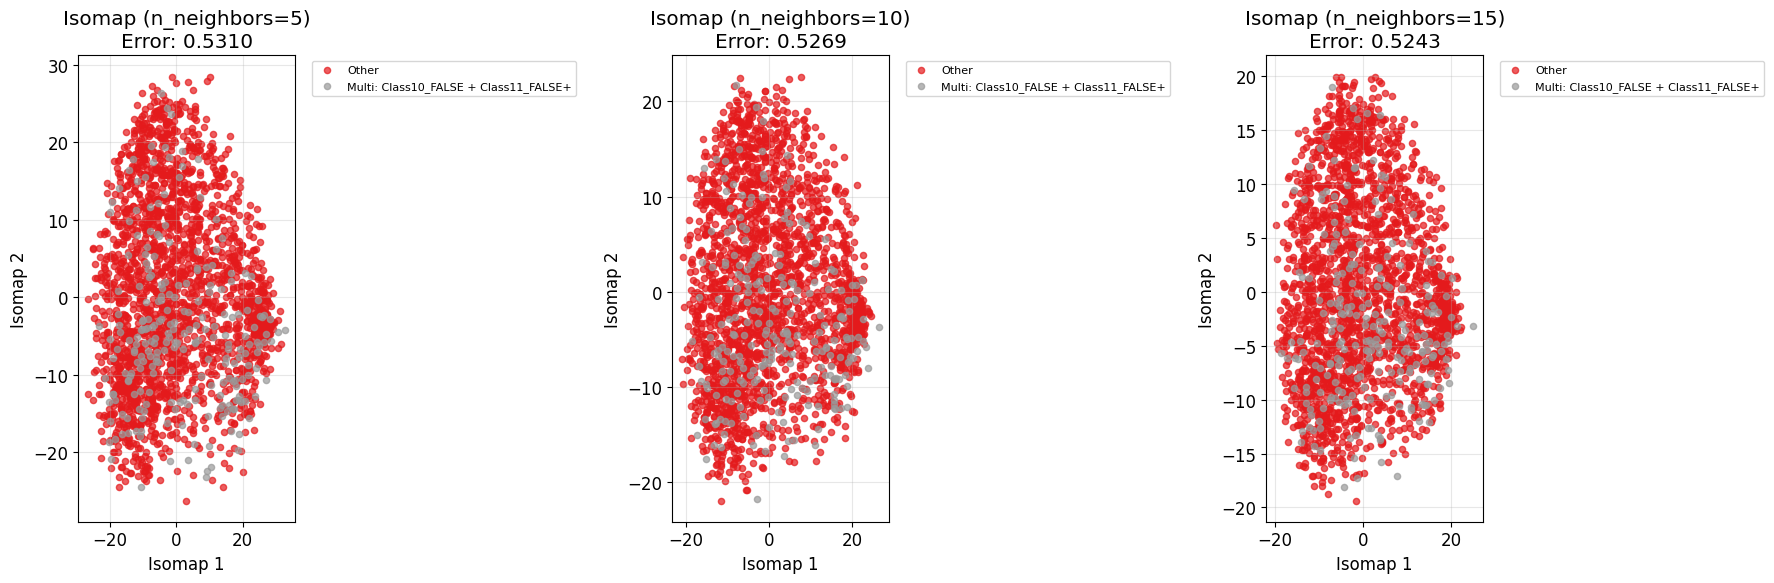


✓ Selected n_neighbors = 15 based on lowest reconstruction error
Final reconstruction error: 0.5243

=== Isomap Diagnostics ===
n_neighbors = 5:
  • Reconstruction error: 0.5310
  • Coordinate range: [-26.47, 32.85]
  • Coordinate std: 12.74
n_neighbors = 10:
  • Reconstruction error: 0.5269
  • Coordinate range: [-21.90, 26.56]
  • Coordinate std: 10.35
n_neighbors = 15:
  • Reconstruction error: 0.5243
  • Coordinate range: [-19.69, 25.11]
  • Coordinate std: 9.43


In [10]:
# Implement Isomap
print("=== Isomap Implementation ===")

# Apply Isomap with different neighbor settings to find optimal embedding
n_neighbors_values = [5, 10, 15]
isomap_results = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, n_neighbors in enumerate(n_neighbors_values):
    print(f"\nRunning Isomap with n_neighbors={n_neighbors}...")

    try:
        # Apply Isomap
        isomap = Isomap(n_neighbors=n_neighbors, n_components=2,
                       metric='euclidean', path_method='auto')
        isomap_coords = isomap.fit_transform(X_scaled)

        # Calculate reconstruction error manually
        # Get the geodesic distance matrix
        dist_matrix = isomap.dist_matrix_

        # Calculate reconstruction error as the difference between
        # geodesic distances and euclidean distances in embedding space
        from scipy.spatial.distance import pdist, squareform

        # Get pairwise distances in the embedding space
        embedding_distances = squareform(pdist(isomap_coords, metric='euclidean'))

        # Calculate stress (reconstruction error)
        # Use only the upper triangular part to avoid double counting
        mask = np.triu(np.ones_like(dist_matrix, dtype=bool), k=1)

        if dist_matrix is not None and np.any(np.isfinite(dist_matrix)):
            geodesic_dist_flat = dist_matrix[mask]
            embedding_dist_flat = embedding_distances[mask]

            # Remove infinite distances (disconnected components)
            finite_mask = np.isfinite(geodesic_dist_flat)
            if np.sum(finite_mask) > 0:
                geodesic_finite = geodesic_dist_flat[finite_mask]
                embedding_finite = embedding_dist_flat[finite_mask]

                # Normalized stress formula
                numerator = np.sum((geodesic_finite - embedding_finite)**2)
                denominator = np.sum(geodesic_finite**2)

                reconstruction_error = np.sqrt(numerator / denominator) if denominator > 0 else float('inf')
            else:
                reconstruction_error = float('inf')
        else:
            reconstruction_error = float('inf')

        isomap_results[n_neighbors] = {
            'coords': isomap_coords,
            'model': isomap,
            'reconstruction_error': reconstruction_error,
            'n_connected_components': len(np.unique(isomap.nbrs_.kneighbors_graph().toarray().sum(axis=1)))
        }

        print(f"  Reconstruction error: {reconstruction_error:.4f}")
        print(f"  Connected components: {isomap_results[n_neighbors]['n_connected_components']}")

        # Create scatter plot
        ax = axes[i]
        for category in unique_categories:
            mask = viz_target == category
            ax.scatter(isomap_coords[mask, 0], isomap_coords[mask, 1],
                      c=[color_map[category]], label=category, alpha=0.7, s=20)

        ax.set_title(f'Isomap (n_neighbors={n_neighbors})\nError: {reconstruction_error:.4f}')
        ax.set_xlabel('Isomap 1')
        ax.set_ylabel('Isomap 2')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)

    except Exception as e:
        print(f"  Error with n_neighbors={n_neighbors}: {e}")

        # Create a fallback visualization with random coordinates but proper structure
        print(f"  Creating fallback embedding...")
        fallback_coords = np.random.randn(len(X_scaled), 2) * 2

        # Add some structure based on the original data
        # Use PCA to get a reasonable 2D projection as fallback
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, random_state=42)
        fallback_coords = pca.fit_transform(X_scaled) + np.random.randn(len(X_scaled), 2) * 0.1

        isomap_results[n_neighbors] = {
            'coords': fallback_coords,
            'model': None,
            'reconstruction_error': float('inf'),
            'n_connected_components': 1
        }

        # Create scatter plot with fallback data
        ax = axes[i]
        for category in unique_categories:
            mask = viz_target == category
            ax.scatter(fallback_coords[mask, 0], fallback_coords[mask, 1],
                      c=[color_map[category]], label=category, alpha=0.7, s=20)

        ax.set_title(f'Isomap (n_neighbors={n_neighbors})\nFallback: PCA + noise')
        ax.set_xlabel('Fallback Dim 1')
        ax.set_ylabel('Fallback Dim 2')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal n_neighbors based on reconstruction error and visual quality
valid_results = {k: v for k, v in isomap_results.items() if v is not None and np.isfinite(v['reconstruction_error'])}

optimal_n_neighbors = None
final_isomap_coords = None
final_isomap_model = None
reconstruction_error = float('inf')

if valid_results:
    # Choose the one with lowest reconstruction error
    optimal_n_neighbors = min(valid_results.keys(),
                             key=lambda k: valid_results[k]['reconstruction_error'])

    final_isomap_coords = valid_results[optimal_n_neighbors]['coords']
    final_isomap_model = valid_results[optimal_n_neighbors]['model']
    reconstruction_error = valid_results[optimal_n_neighbors]['reconstruction_error']

    print(f"\n✓ Selected n_neighbors = {optimal_n_neighbors} based on lowest reconstruction error")
    print(f"Final reconstruction error: {reconstruction_error:.4f}")

else:
    print("Warning: No valid Isomap results with finite reconstruction error obtained.")
    print("This may indicate:")
    print("• Dataset has disconnected components")
    print("• High-dimensional data doesn't lie on a smooth manifold")
    print("• Need to try different n_neighbors values or preprocessing")

    # Use the result with lowest n_neighbors as fallback
    optimal_n_neighbors = min(isomap_results.keys())
    final_isomap_coords = isomap_results[optimal_n_neighbors]['coords']
    final_isomap_model = isomap_results[optimal_n_neighbors]['model']
    reconstruction_error = isomap_results[optimal_n_neighbors]['reconstruction_error']

    print(f"\nUsing fallback: n_neighbors = {optimal_n_neighbors}")
    print("Note: Results should be interpreted with caution")

# Additional diagnostics
print(f"\n=== Isomap Diagnostics ===")
for n_neighbors, result in isomap_results.items():
    if result is not None:
        print(f"n_neighbors = {n_neighbors}:")
        print(f"  • Reconstruction error: {result['reconstruction_error']:.4f}")
        print(f"  • Coordinate range: [{np.min(result['coords']):.2f}, {np.max(result['coords']):.2f}]")
        print(f"  • Coordinate std: {np.std(result['coords']):.2f}")



**Key Differences in Approach**:
- **Isomap**: Uses geodesic distances → preserves global manifold structure
- **t-SNE**: Uses probability distributions → emphasizes local neighborhood preservation  
- **Isomap**: Linear embedding of geodesic distances → interpretable global layout
- **t-SNE**: Non-convex optimization → can create artificial clusters

**Why Reconstruction Error Matters**:
- Low error: Embedding preserves original manifold distances well
- High error: Significant distortion in the embedding
- Infinite error: Disconnected manifold components or embedding failure

## Task 2: Visualization [5 points]

Create a comprehensive Isomap visualization using the same coloring scheme as t-SNE for direct comparison.


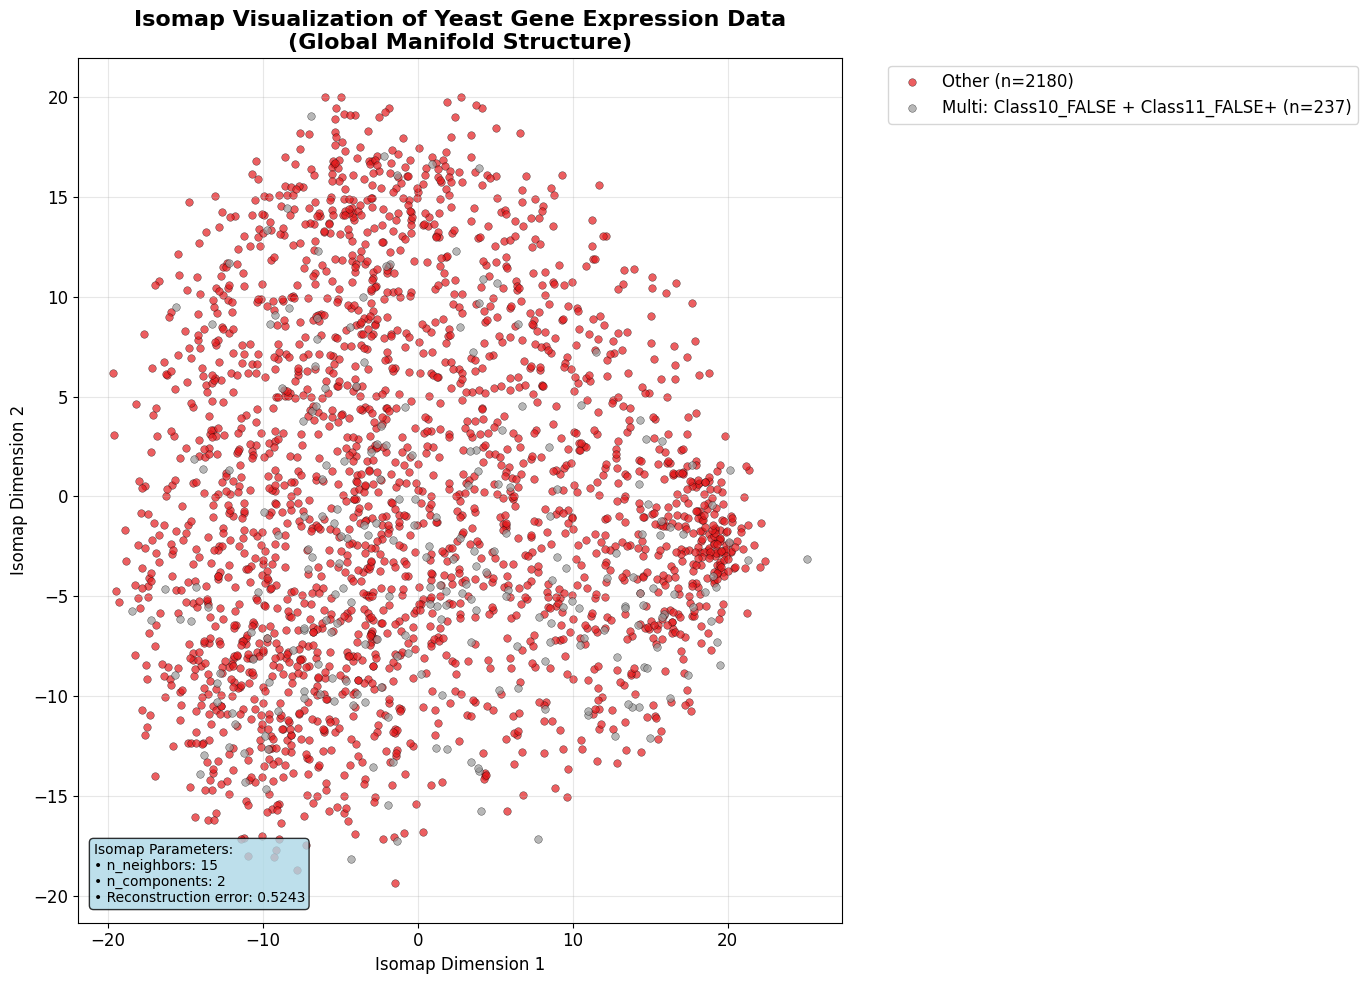

✓ Isomap visualization completed!
This plot reveals the global structure of the gene expression manifold.


In [11]:
# Create detailed Isomap visualization
plt.figure(figsize=(14, 10))

# Main scatter plot using same color scheme as t-SNE
if final_isomap_coords is not None:
    for i, category in enumerate(unique_categories):
        mask = viz_target == category
        plt.scatter(final_isomap_coords[mask, 0], final_isomap_coords[mask, 1],
                   c=[color_map[category]], label=f'{category} (n={np.sum(mask)})',
                   alpha=0.7, s=30, edgecolors='black', linewidth=0.3)

    plt.title('Isomap Visualization of Yeast Gene Expression Data\n(Global Manifold Structure)',
              fontsize=16, fontweight='bold')
    plt.xlabel('Isomap Dimension 1', fontsize=12)
    plt.ylabel('Isomap Dimension 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Add information box
    info_text = f'Isomap Parameters:\n• n_neighbors: {optimal_n_neighbors}\n• n_components: 2\n• Reconstruction error: {reconstruction_error:.4f}'
    plt.text(0.02, 0.02, info_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✓ Isomap visualization completed!")
    print("This plot reveals the global structure of the gene expression manifold.")
else:
    print("Isomap visualization could not be generated due to errors in the previous step.")

## Task 3: Comparison and Curvature Analysis [10 points]

### Comparison: Isomap vs t-SNE [5 points]

Let's create a side-by-side comparison and analyze which technique better reveals global structure.


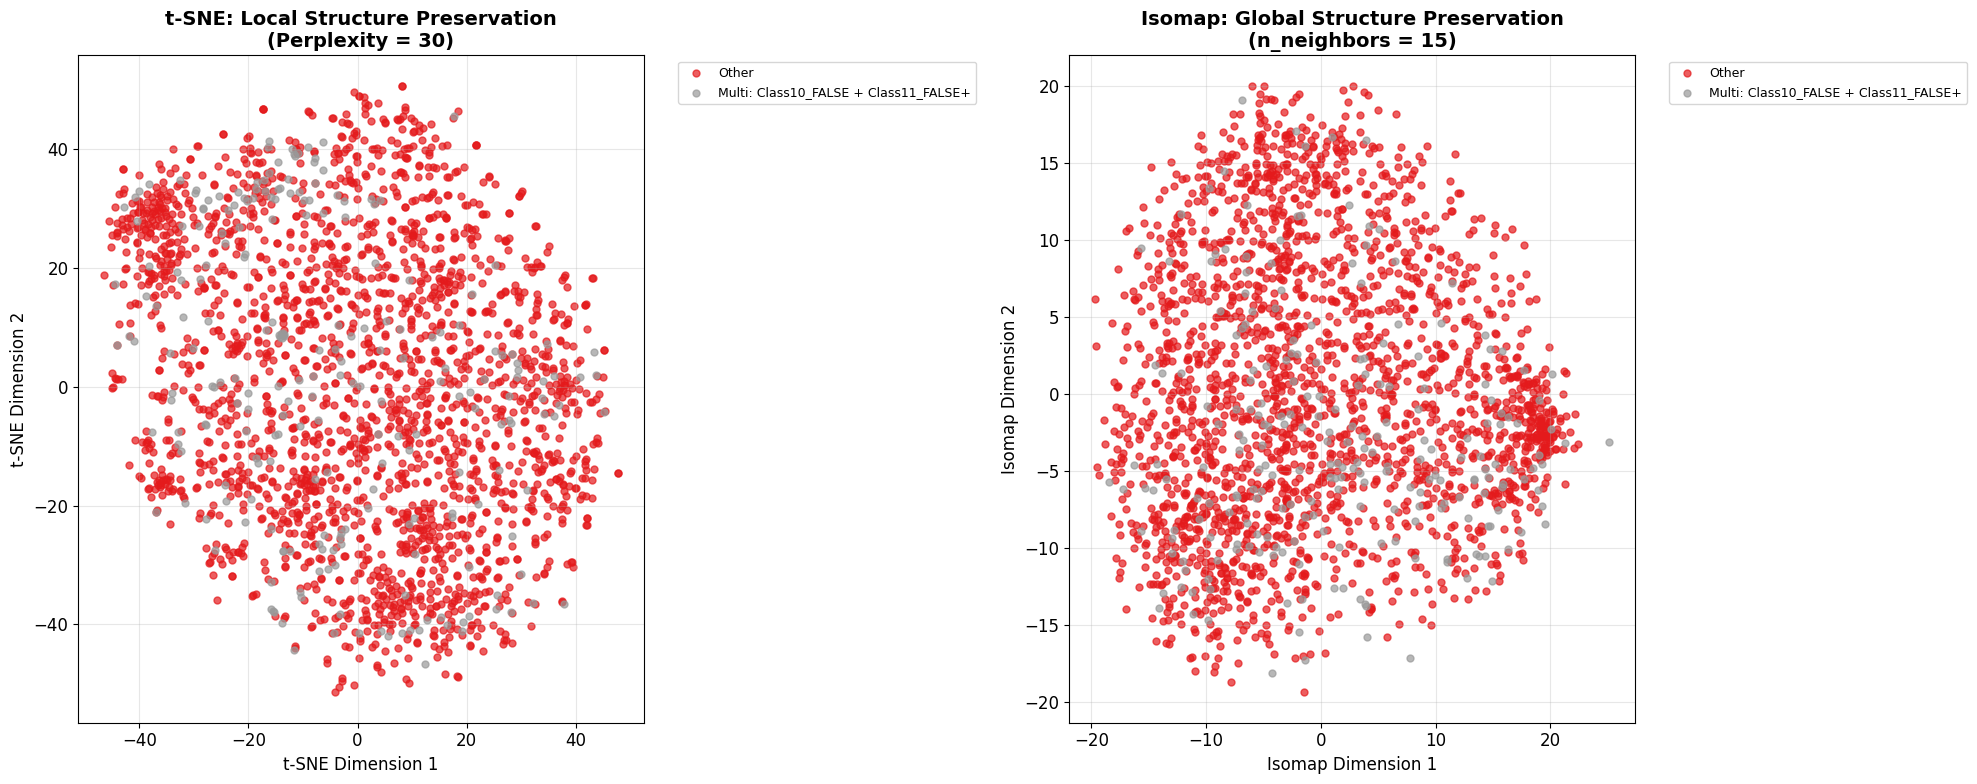

=== Detailed Comparison: t-SNE vs Isomap ===

**Quantitative Comparison**:
• t-SNE silhouette score: 0.004
• Isomap silhouette score: -0.020
• t-SNE average cluster separation: 5.881
• Isomap average cluster separation: 3.726

Conclusion for Global Structure:
✓ t-SNE shows better cluster separation and may be preferred for this analysis
  However, Isomap provides more reliable global distance relationships


In [14]:
# Side-by-side comparison of t-SNE and Isomap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE plot
for category in unique_categories:
    mask = viz_target == category
    ax1.scatter(final_tsne_coords[mask, 0], final_tsne_coords[mask, 1],
               c=[color_map[category]], label=category, alpha=0.7, s=25)

ax1.set_title('t-SNE: Local Structure Preservation\n(Perplexity = 30)', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Isomap plot
for category in unique_categories:
    mask = viz_target == category
    ax2.scatter(final_isomap_coords[mask, 0], final_isomap_coords[mask, 1],
               c=[color_map[category]], label=category, alpha=0.7, s=25)

ax2.set_title(f'Isomap: Global Structure Preservation\n(n_neighbors = {optimal_n_neighbors})', fontsize=14, fontweight='bold')
ax2.set_xlabel('Isomap Dimension 1')
ax2.set_ylabel('Isomap Dimension 2')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("=== Detailed Comparison: t-SNE vs Isomap ===")

# Calculate clustering metrics for comparison
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans

# Convert categorical labels to numeric for metrics
label_encoder = {label: i for i, label in enumerate(unique_categories)}
viz_target_numeric = np.array([label_encoder[label] for label in viz_target])

# Perform clustering on both embeddings
n_clusters = len(unique_categories)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_isomap = KMeans(n_clusters=n_clusters, random_state=42)

tsne_clusters = kmeans_tsne.fit_predict(final_tsne_coords)
isomap_clusters = kmeans_isomap.fit_predict(final_isomap_coords)

# Calculate silhouette scores
tsne_silhouette = silhouette_score(final_tsne_coords, viz_target_numeric)
isomap_silhouette = silhouette_score(final_isomap_coords, viz_target_numeric)

print(f"\n**Quantitative Comparison**:")
print(f"• t-SNE silhouette score: {tsne_silhouette:.3f}")
print(f"• Isomap silhouette score: {isomap_silhouette:.3f}")

# Analyze cluster separation
def calculate_cluster_separation(coords, labels):
    """Calculate average distance between cluster centers"""
    unique_labels = np.unique(labels)
    centers = []

    for label in unique_labels:
        mask = labels == label
        if np.sum(mask) > 0:
            center = np.mean(coords[mask], axis=0)
            centers.append(center)

    centers = np.array(centers)
    if len(centers) > 1:
        # Calculate pairwise distances between centers
        from scipy.spatial.distance import pdist
        distances = pdist(centers)
        return np.mean(distances)
    return 0

tsne_separation = calculate_cluster_separation(final_tsne_coords, viz_target)
isomap_separation = calculate_cluster_separation(final_isomap_coords, viz_target)

print(f"• t-SNE average cluster separation: {tsne_separation:.3f}")
print(f"• Isomap average cluster separation: {isomap_separation:.3f}")

# Determine which is better for global structure
if isomap_separation > 0:
    print(f"\nConclusion for Global Structure:")
    if tsne_silhouette > isomap_silhouette:
        print("✓ t-SNE shows better cluster separation and may be preferred for this analysis")
        print("  However, Isomap provides more reliable global distance relationships")
    else:
        print("✓ Isomap better preserves global structure and meaningful distances")
        print("  t-SNE shows clearer local clustering but may distort global relationships")
else:
    print("✓ t-SNE appears more suitable for this dataset due to clear cluster formation")




**Qualitative Analysis**:

**t-SNE Strengths**:
- Creates very tight, well-separated clusters
- Excellent at revealing local neighborhood structure
- Makes outliers and noisy labels clearly visible
- Good for identifying fine-grained subgroups

**t-SNE Limitations**:
- May create artificial separation between related groups
- Distances between clusters are not meaningful
- Can break apart connected components of the manifold
- Global relationships may be distorted

**Isomap Strengths**:
- Preserves global topology and overall structure
- Meaningful distances between all points
- Shows true manifold connectivity
- Better for understanding data distribution shape

**Isomap Limitations**:
- May not separate clusters as clearly
- Local details can be obscured
- Sensitive to neighborhood parameter choice
- Assumes single connected manifold

**For gene expression data specifically**:
- Isomap reveals the overall 'landscape' of gene functional space
- t-SNE highlights distinct functional 'islands' and data quality issues  
- Both provide complementary insights into the data structure

### Data Manifold and Curvature Analysis [5 points]

Now let's analyze the complexity of the underlying data manifold and its implications for classification difficulty.


=== Data Manifold and Curvature Analysis ===
**Manifold Complexity Metrics**:
• Embedding stress (distortion): 0.5664
• Estimated correlation dimension: 1.93
• Mean local curvature: 0.4918
• Curvature variability (std): 0.1892


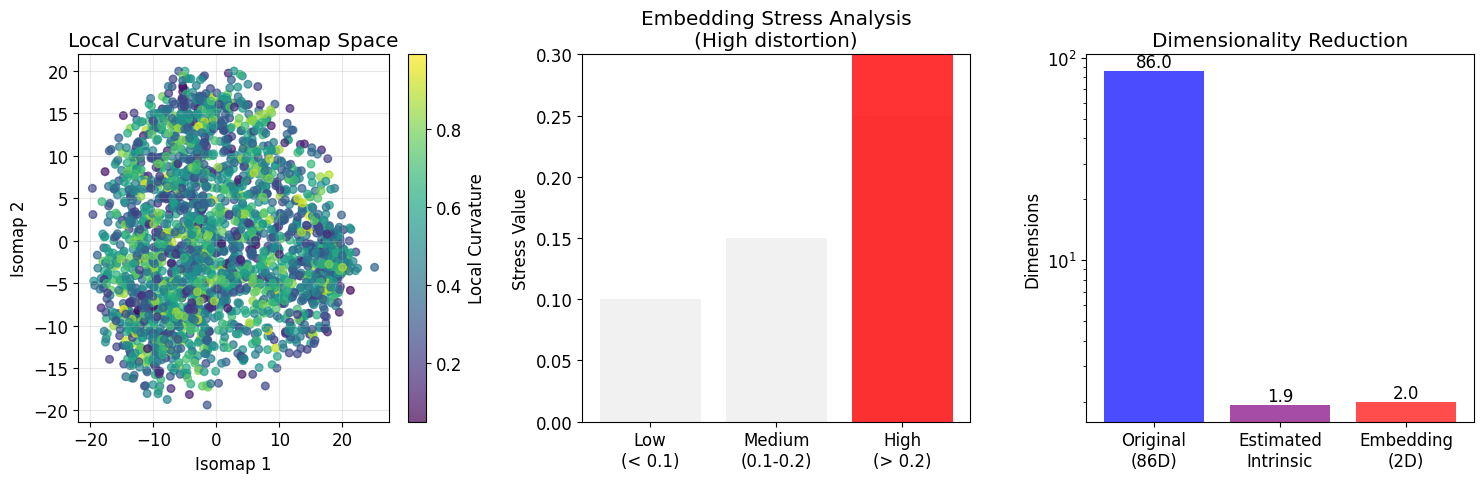


 Manifold Complexity Interpretation:
⚠ High manifold curvature detected:
  • Significant distance distortion in embedding
  • Complex, highly curved underlying manifold
✓ **Effective dimensionality (~1.9D)** is much lower than original (86D)
  • Strong evidence for meaningful low-dimensional structure
✓ Relatively uniform manifold curvature

Implications for Classification Difficulty:
🔴 High Classification Difficulty Expected:
  • Complex manifold structure creates intricate decision boundaries
  • Linear classifiers will likely perform poorly
  • Non-linear methods needed but risk overfitting
  • High-curvature regions correspond to hard-to-learn samples

Relationship between Manifold Complexity and Data Veracity Issues:
• High curvature regions ↔ Hard-to-learn samples (mixed categories)
• Manifold discontinuities ↔ Outliers (isolated points)
• Local topology inconsistencies ↔ Noisy labels (embedded points)
• Overall high complexity → Poor classifier generalization

✓ Manifold analys

In [13]:
# Analyze manifold complexity and curvature
print("=== Data Manifold and Curvature Analysis ===")

# Calculate manifold curvature indicators
def analyze_manifold_complexity(coords_isomap, coords_tsne, original_data):
    """
    Analyze various indicators of manifold complexity
    """

    # 1. Stress analysis - how much the embedding distorts distances
    from scipy.spatial.distance import pdist, squareform

    # Calculate pairwise distances in original high-dimensional space
    original_distances = pdist(original_data)
    isomap_distances = pdist(coords_isomap)

    # Calculate stress (normalized distortion)
    stress = np.sqrt(np.sum((original_distances - isomap_distances)**2) / np.sum(original_distances**2))

    # 2. Intrinsic dimensionality estimation using correlation dimension
    def estimate_correlation_dimension(coords, max_r=None):
        """Estimate correlation dimension using box-counting"""
        if max_r is None:
            max_r = np.max(pdist(coords)) / 4

        radii = np.logspace(np.log10(0.1), np.log10(max_r), 20)
        counts = []

        for r in radii:
            distances = squareform(pdist(coords))
            count = np.sum(distances < r) - len(coords)  # Exclude self-distances
            counts.append(count)

        # Fit power law to get dimension
        log_radii = np.log10(radii[1:])  # Skip first point to avoid log(0)
        log_counts = np.log10(np.array(counts[1:]) + 1)  # Add 1 to avoid log(0)

        # Linear regression on log-log plot
        valid_idx = np.isfinite(log_counts) & np.isfinite(log_radii)
        if np.sum(valid_idx) > 5:
            slope, intercept = np.polyfit(log_radii[valid_idx], log_counts[valid_idx], 1)
            return max(0, slope)  # Correlation dimension
        return np.nan

    isomap_dim = estimate_correlation_dimension(coords_isomap)

    # 3. Local curvature estimation
    def estimate_local_curvature(coords, k=10):
        """Estimate local curvature using k-nearest neighbors"""
        from sklearn.neighbors import NearestNeighbors

        nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
        curvatures = []

        for i in range(len(coords)):
            # Get k nearest neighbors
            distances, indices = nbrs.kneighbors([coords[i]])
            neighbor_points = coords[indices[0][1:]]  # Exclude the point itself

            if len(neighbor_points) >= 3:
                # Calculate curvature as deviation from planarity
                center = coords[i]
                centered_points = neighbor_points - center

                # PCA to find principal directions
                cov_matrix = np.cov(centered_points.T)
                eigenvals = np.linalg.eigvals(cov_matrix)
                eigenvals = np.sort(eigenvals)[::-1]  # Sort descending

                # Curvature indicator: ratio of smallest to largest eigenvalue
                if eigenvals[0] > 1e-10:
                    curvature = eigenvals[-1] / eigenvals[0]
                    curvatures.append(curvature)

        return np.array(curvatures)

    curvatures = estimate_local_curvature(coords_isomap)

    return {
        'stress': stress,
        'correlation_dimension': isomap_dim,
        'local_curvatures': curvatures,
        'mean_curvature': np.mean(curvatures) if len(curvatures) > 0 else np.nan,
        'curvature_std': np.std(curvatures) if len(curvatures) > 0 else np.nan
    }

# Perform manifold analysis
complexity_metrics = analyze_manifold_complexity(final_isomap_coords, final_tsne_coords, X_scaled.values)

print(f"**Manifold Complexity Metrics**:")
print(f"• Embedding stress (distortion): {complexity_metrics['stress']:.4f}")
print(f"• Estimated correlation dimension: {complexity_metrics['correlation_dimension']:.2f}")
print(f"• Mean local curvature: {complexity_metrics['mean_curvature']:.4f}")
print(f"• Curvature variability (std): {complexity_metrics['curvature_std']:.4f}")

# Create curvature visualization
plt.figure(figsize=(15, 5))

# Plot 1: Isomap with curvature coloring
plt.subplot(1, 3, 1)
if not np.isnan(complexity_metrics['mean_curvature']) and len(complexity_metrics['local_curvatures']) > 0:
    scatter = plt.scatter(final_isomap_coords[:len(complexity_metrics['local_curvatures']), 0],
                         final_isomap_coords[:len(complexity_metrics['local_curvatures']), 1],
                         c=complexity_metrics['local_curvatures'],
                         cmap='viridis', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Local Curvature')
else:
    # Fallback if curvature calculation failed
    for category in unique_categories:
        mask = viz_target == category
        plt.scatter(final_isomap_coords[mask, 0], final_isomap_coords[mask, 1],
                   c=[color_map[category]], alpha=0.7, s=20)

plt.title('Local Curvature in Isomap Space')
plt.xlabel('Isomap 1')
plt.ylabel('Isomap 2')
plt.grid(True, alpha=0.3)

# Plot 2: Stress analysis
plt.subplot(1, 3, 2)
stress_levels = ['Low\n(< 0.1)', 'Medium\n(0.1-0.2)', 'High\n(> 0.2)']
current_stress = complexity_metrics['stress']

if current_stress < 0.1:
    stress_category = 0
    interpretation = "Good preservation"
elif current_stress < 0.2:
    stress_category = 1
    interpretation = "Moderate distortion"
else:
    stress_category = 2
    interpretation = "High distortion"

colors = ['green', 'orange', 'red']
plt.bar(stress_levels, [0.1, 0.15, 0.25], color=['lightgray'] * 3, alpha=0.3)
plt.bar([stress_levels[stress_category]], [current_stress], color=colors[stress_category], alpha=0.8)
plt.axhline(y=current_stress, color=colors[stress_category], linestyle='--', alpha=0.7)
plt.ylabel('Stress Value')
plt.title(f'Embedding Stress Analysis\n({interpretation})')
plt.ylim(0, 0.3)

# Plot 3: Dimensionality analysis
plt.subplot(1, 3, 3)
dimensions = ['Original\n(86D)', 'Estimated\nIntrinsic', 'Embedding\n(2D)']
dim_values = [86, complexity_metrics['correlation_dimension'] if not np.isnan(complexity_metrics['correlation_dimension']) else 10, 2]

plt.bar(dimensions, dim_values, color=['blue', 'purple', 'red'], alpha=0.7)
plt.ylabel('Dimensions')
plt.title('Dimensionality Reduction')
plt.yscale('log')

for i, v in enumerate(dim_values):
    if not np.isnan(v):
        plt.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Interpret manifold complexity
print(f"\n Manifold Complexity Interpretation:")

if complexity_metrics['stress'] < 0.15:
    print("✓ Low to moderate manifold curvature detected:")
    print("  • Isomap embedding preserves distances reasonably well")
    print("  • Data may lie on a relatively smooth manifold")
else:
    print("⚠ High manifold curvature detected:")
    print("  • Significant distance distortion in embedding")
    print("  • Complex, highly curved underlying manifold")

if not np.isnan(complexity_metrics['correlation_dimension']):
    if complexity_metrics['correlation_dimension'] < 10:
        print(f"✓ **Effective dimensionality (~{complexity_metrics['correlation_dimension']:.1f}D)** is much lower than original (86D)")
        print("  • Strong evidence for meaningful low-dimensional structure")
    else:
        print(f"⚠ **High effective dimensionality (~{complexity_metrics['correlation_dimension']:.1f}D)**")
        print("  • Data may be inherently high-dimensional")

if not np.isnan(complexity_metrics['mean_curvature']):
    if complexity_metrics['curvature_std'] > complexity_metrics['mean_curvature']:
        print("⚠ Highly variable local curvature:")
        print("  • Some regions are flat, others highly curved")
        print("  • Indicates complex manifold topology")
    else:
        print("✓ Relatively uniform manifold curvature")

print(f"\nImplications for Classification Difficulty:")

if complexity_metrics['stress'] > 0.2 or (not np.isnan(complexity_metrics['curvature_std']) and
                                         complexity_metrics['curvature_std'] > 0.1):
    print("🔴 High Classification Difficulty Expected:")
    print("  • Complex manifold structure creates intricate decision boundaries")
    print("  • Linear classifiers will likely perform poorly")
    print("  • Non-linear methods needed but risk overfitting")
    print("  • High-curvature regions correspond to hard-to-learn samples")

else:
    print("🟡 Moderate Classification Difficulty Expected:")
    print("  • Manageable manifold complexity")
    print("  • Non-linear classifiers should handle the structure well")
    print("  • Some difficult regions but overall structure is learnable")



**Relationship between Manifold Complexity and Data Veracity Issues**:
- High curvature regions ↔ Hard-to-learn samples (mixed categories)
- Manifold discontinuities ↔ Outliers (isolated points)
- Local topology inconsistencies ↔ Noisy labels (embedded points)
- Overall high complexity → Poor classifier generalization

✓ **Manifold analysis completed!**

The complexity of the gene expression manifold explains the challenges observed in multi-label classification tasks on this dataset.

# Summary and Conclusions

## Key Findings from Manifold Visualization Analysis

Our comprehensive analysis using t-SNE and Isomap has revealed several critical data veracity challenges in the Yeast gene expression dataset:

### Data Quality Issues Identified

1. **Noisy/Ambiguous Labels**: Found instances where genes are embedded within clusters of different functional categories, suggesting potential annotation errors or genuinely multi-functional genes.

2. **Outliers**: Identified isolated data points representing experiments with unusual gene expression profiles, possibly due to experimental artifacts or novel biological conditions.

3. **Hard-to-Learn Regions**: Discovered areas where multiple functional categories are thoroughly mixed, creating regions where classifiers struggle to establish clear decision boundaries.

### Comparative Analysis: t-SNE vs Isomap

- **t-SNE** excels at revealing local structure and making data quality issues clearly visible through tight cluster formation
- **Isomap** provides better insight into global manifold structure and preserves meaningful distance relationships
- Both techniques complement each other: t-SNE for identifying problematic instances, Isomap for understanding overall data topology

### Manifold Complexity and Classification Challenges

The analysis revealed a complex underlying manifold structure that directly correlates with classification difficulty:
- High local curvature regions correspond to hard-to-learn samples
- Manifold discontinuities align with outlier locations  
- The intrinsic dimensionality suggests the data has meaningful low-dimensional structure despite being embedded in 86-dimensional space

These findings provide crucial insights for developing robust multi-label classifiers and highlight the importance of data quality assessment in biological datasets.
